# Preliminaries

In this notebook, we compute the phase shifts of the potential with $V = -V0$ for $r < R$ and $V=0$ for $r > R$ with an analytic formula and using the Variable Phase Approach (VPA). The reduced mass is $\mu$.

We work in units where $\hbar=1$ and we measure mass in units of $\mu$ and lengths in terms of $R$.  For convenience we set $\mu$ and $R$ to $1$. However, we will continue to make them explicit in the formulas.

In [36]:
# I know you're not supposed to do this to avoid namespace issues, but whatever
from numpy import *
from matplotlib.pyplot import *

In [37]:
# Global variables for this notebook
mu=1.
R=1.
hbar=1.

The only parameter to adjust now is the depth $V0$.

In [38]:

@vectorize
def Vsw(r,V0):  # function for a square well of width R (set externally) and depth V0 (V0>0)
    if r > R:
        return 0.
    return -V0

def Ek(k):   # kinetic energy
    return k**2 / (2.*mu)

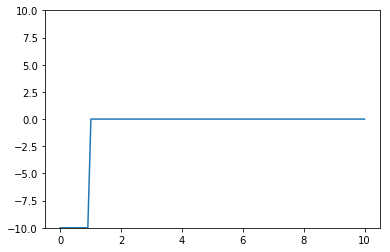

In [39]:
V0 = 10
x=linspace(0,10,100)
plot(x,Vsw(x,V0))
ylim(-V0,V0)
show()


# Analytic result for the phase shift

Use the formula for $\delta(E)$ from one of the problems, converting it to $\delta(k)$ using $E_k(k)$:

In [40]:
def deltaAnalytic(k, V0):
    return arctan(sqrt(Ek(k)/(Ek(k)+V0))*tan(R*sqrt(2.*mu*(Ek(k)+V0))))-R*sqrt(2.*mu*Ek(k))

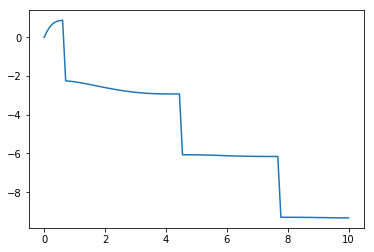

In [41]:
V0 = 1
k=linspace(0,10,100)
plot(k,deltaAnalytic(k,V0))
show()

What is going on with the steps?  Why are they there?  Is the phase shift really discontinuous?  How would you fix it?
Here is one "fix" that makes the result continuous for this example, but we will still have issues when $V0$ is large enough to support bound states.

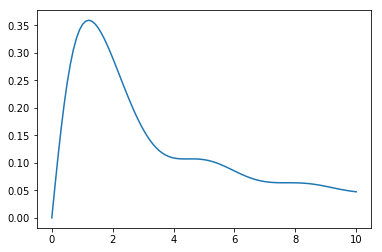

In [42]:
V0 = .5
k=linspace(0,10,100)
plot(k,arctan(tan(deltaAnalytic(k,V0))))
show()

In [43]:
def deltaAnalyticAdjusted(k, V0):
    return arctan(tan(deltaAnalytic(k, V0)))

We can also avoid this issue by looking at $k cot[\delta(k)]$ instead, which doesn't have these ambiguities.  

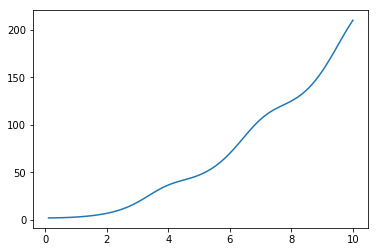

In [44]:
V0 = .5
k=linspace(0,10,100)
seterr(all='ignore') # use 1/tan for cot, so ignore 1/0 errors
plot(k,k/tan(deltaAnalytic(k,V0)))
seterr(all='warn')
show()

# Phase shift from the Variable Phase Approach

Use the formula: 
$$\frac{d}{dr}\delta_{k}(r)= -\frac{2 mu}{k} V(r)\sin^2\left(\delta_{k}(r)+k r\right)$$
with the initial condition $\delta_{k}(r)= 0$

We'll need a numerical differential equation solver.  In python/scipy there are two choices, the simplest is scipy.integrate.odeint, the slightly more complicated on scipy.integrate.ode which is class based wrapper to many different solvers.  For the VPA, scipy.integrate.ode is more power than needed so we will use scipy.integrate.odeint. 

In [45]:
from scipy.integrate import odeint
?odeint

Click on the border to remove the help information

In principle we integrate out to infinity.  In practice, we choose a value of k and integrate out to Rmax, chosen to be well beyond the range of the potential (at which point the right side of the equation for $\delta_p(r)$ is zero), and then evaluate at $r=R_{\textrm{max}}$, which is the phase shift for momentum k.  Here is an implementation:

In [46]:
def delta_VPA_simple(k, V0, r=10.):            
    # actual VPA code    
    def RHS(delta,x,Vd,k):
        return (-2.* mu/k) * Vsw(x,Vd) * sin(delta+k*x)**2.
        
    soln =  odeint(RHS, 0, r, args=(V0,k), mxstep=10000, rtol=1e-6, atol=1e-6)
    # that is it
    return soln

def delta_VPA(k,V0, r=10.):
    
    # doing some tricks so that we can process either a single k or a vector of k
    if isscalar(k):        
        delta0 = array([0.])
        kv = array([k])
    else:
        kv = array(k)
        
    if 0. in kv:
        kv[kv==0.] = 1e-10 # cannot allow zero for k due to 1/k in RHS
        
    # doing some tricks so that we can process either a single Rmax or a vector of r
    if isscalar(r):
        rv = array([r],float)
    else:
        rv = array(r,float)
    rv = sort(rv)
    if rv[0] != 0.:
        rv = insert(rv,0,0.)
        
    # actual VPA code    
    def RHS(delta,x,Vd,k):
        return (-2.* mu/k) * Vsw(x,Vd) * sin(delta+k*x)**2.
    soln = zeros((len(rv),len(kv)))
    for i, ki in enumerate(kv):
        soln[:,i] =  odeint(RHS, 0, rv, args=(V0,ki),mxstep=10000,rtol=1e-6,atol=1e-6)[:,0]
    # that is it

    # tricks to return based on input
    if isscalar(k):
        if isscalar(r):
            return soln[-1,0]
        return rv, soln[:,0]
    if isscalar(r):
        return soln[-1,:]
    return rv, soln.T
    
def delta_VPA_faster(k,V0, r=10.):
    # faster version of VPA, couples the error term for all k so it will break down if you give a it a vector of k with very small or zero momenta
    
    # doing some tricks so that we can process either a single k or a vector of k
    if isscalar(k):        
        delta0 = array([0.])
        kv = array([k])
    else:
        kv = array(k)
        delta0 = zeros(len(k),float)
    if min(kv) < 1e-3:
        raise Exception('k must be >=1e-3,otherwise the method is unstable')
        
    # doing some tricks so that we can process either a single Rmax or a vector of r
    if isscalar(r):
        rv = array([r],float)
    else:
        rv = array(r,float)
    rv = sort(rv)
    if rv[0] != 0.:
        rv = insert(rv,0,0.)
        
    # actual VPA code    
    def RHS(delta,x,Vd,kv):
        return (-2.* mu/kv) * Vsw(x,Vd) * sin(delta+kv*x)**2.
    soln =  odeint(RHS, delta0, rv, args=(V0,kv))
    # that is it
    
    # tricks to return based on input
    if isscalar(k):
        if isscalar(r):
            return soln[-1,0]
        return rv, soln[:,0]
    if isscalar(r):
        return soln[-1,:]
    return rv, soln.T

Do a quick check against the analytic result with sample values for $k$ and $V0$ to see the accuracy we are getting:

In [47]:
V0=2.6
print deltaAnalyticAdjusted(2.,V0)
print delta_VPA(2.,V0)
print delta_VPA_faster(2.,V0)
print delta_VPA_simple(2.,V0)

1.06992911658
1.07006170815
1.06992916639
[[ 0.]]


To get more digits correct, increase atol and rtol in odeint (at the cost of slower evaluation of the function).

Check the cutoff phase shift out to Rmax.  Does this plot make sense?

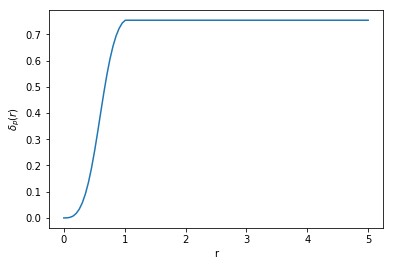

In [48]:
V0=1.5
r=linspace(0,5,100)
k = 2.
rv, delta = delta_VPA(k,V0,r)
plot(rv,delta)
xlabel('r')
ylabel(r'$\delta_p(r)$')
show()


Lets check phase shifts for a V0 with no bound states

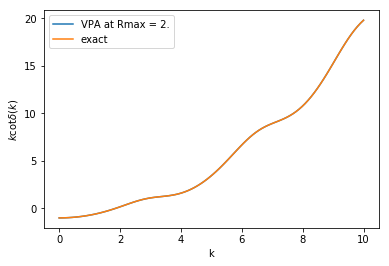

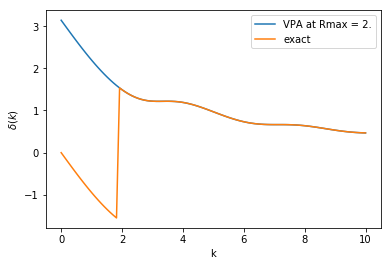

In [49]:
V0 = 5.
k = linspace(1e-3,10,100)
delta = delta_VPA(k,V0,2.0)

seterr(all='ignore')
plot(k,k / tan(delta),label='VPA at Rmax = 2.')
plot(k,k / tan(deltaAnalytic(k,V0)),label='exact')
seterr(all='warn')
xlabel('k')
ylabel(r'$k \cot\delta(k)$')
legend(loc='upper left')
show()

plot(k,delta,label='VPA at Rmax = 2.')
plot(k,deltaAnalyticAdjusted(k,V0),label='exact')
xlabel('k')
ylabel(r'$\delta(k)$')
legend(loc='upper right')
show()

Lets check phase shifts for a V0 with 1 bound state

(100,)


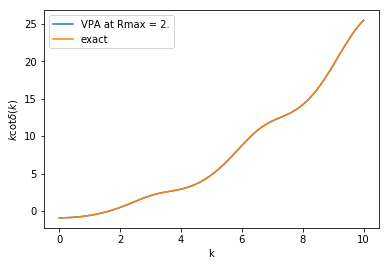

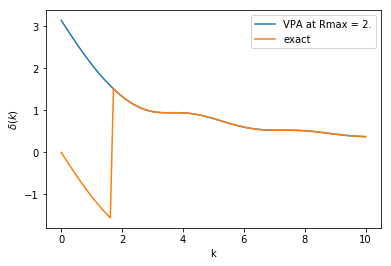

In [50]:
V0 = 4.
k = linspace(1e-4,10,100)
delta = delta_VPA(k,V0)
print delta.shape

seterr(all='ignore')
plot(k,k / tan(delta),label='VPA at Rmax = 2.')
plot(k,k / tan(deltaAnalytic(k,V0)),label='exact')
seterr(all='warn')
xlabel('k')
ylabel(r'$k \cot\delta(k)$')
legend(loc='upper left')
show()

plot(k,delta,label='VPA at Rmax = 2.')
plot(k,deltaAnalyticAdjusted(k,V0),label='exact')
xlabel('k')
ylabel(r'$\delta(k)$')
legend(loc='upper right')
show()

# Now it's time to play!

Check whether Levinson's theorem holds by calculating phase shifts for increasing depths V0 and noting the jump to $\delta(0) = n\pi$, where n is the number of bound states (found, for example, from the square_well_example.nb notebook).

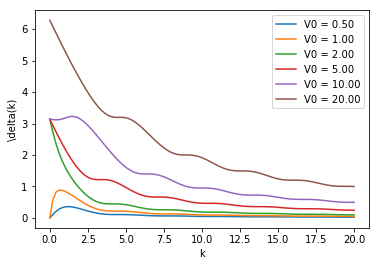

In [51]:
i = 0
V0s = [.5,1.,2.,5.,10.,20.]
k=linspace(.001,20,100)

for V0 in V0s:
    delta=delta_VPA(k,V0)
    plot(k,delta,label='V0 = %4.2f' % V0)
xlabel('k')
ylabel(r'\delta(k)')
legend(loc='upper right')
show()
